In [23]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
# ! pip install pandas_datareader
import pandas_datareader.data as web

from sklearn.model_selection import train_test_split as tts
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import tree

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.metrics import classification_report

from sklearn import metrics

import seaborn as sns

In [24]:
rawCovid = pd.read_csv("covid.csv")
variables = ["submission_date", "tot_cases", "new_case", "tot_death", "new_death"]
covid = rawCovid.loc[:,variables]

In [25]:
covid["submission_date"] = pd.to_datetime(covid["submission_date"])
covid.rename(columns={"submission_date":"Date"}, inplace=True)

In [26]:
weeklyCovid = covid.groupby(pd.Grouper(key = "Date", freq ="W")).sum()
weeklyCovid.reset_index(inplace=True)

weeklyCovid["case_change"] = weeklyCovid["tot_cases"].diff().fillna(0)
weeklyCovid.loc[weeklyCovid["new_case"] != 0, "case_change"] = weeklyCovid["case_change"]/weeklyCovid["new_case"]
weeklyCovid["death_change"] = weeklyCovid["tot_death"].diff().fillna(0)
weeklyCovid.loc[weeklyCovid["new_death"] != 0, "death_change"] = weeklyCovid["death_change"]/weeklyCovid["new_death"]

In [27]:
bioStock = ["FBRX", "TRIL", "CODX", "ALIM", "BTAI"]
pharmStock = ["ABT", "RCUS", "LLY", "ELAN", "MRK"]
techStocks = ["BILI", "CCOI", "CHT"]
energyStocks = ["CVX","XOM","KMI","WMB","LNG"]
retailStocks = ["WMT","AMZN","COST","BIG","ACI"]
consumerStaplesStocks= ['VDC', 'VCSAX']
utilityStocks= [ 'VUIAX', 'VPU']
realEstateStocks = ['AMT', 'PLD', 'EQIX', 'BAM', 'ZG']
healthCareStocks = ['JNJ', 'MDT', 'NVS', 'PFE', 'GSK']

In [28]:
tickerSymbol = bioStock + pharmStock + techStocks + energyStocks + retailStocks + consumerStaplesStocks + utilityStocks + realEstateStocks + healthCareStocks

In [29]:
start = "2020-01-22"
end = dt.now()

stocks = pd.DataFrame()
sc_df = pd.DataFrame()

for i in tickerSymbol:
    df = web.DataReader(i, "yahoo", start, end)
    df.reset_index(inplace=True)

    weeklyPrice = df.groupby([pd.Grouper(key="Date", freq="W")]).mean()
    weeklyPrice["Stock"] = i
    weeklyPrice.reset_index(inplace=True)
    weeklyPrice["stock_price_change"] = weeklyPrice["Adj Close"].diff().fillna(0)
    weeklyPrice["stock_price_change"] = weeklyPrice["stock_price_change"]/weeklyPrice["Adj Close"]
    
    
    stocks = stocks.append(weeklyPrice[["Adj Close", "Date", "Stock", "stock_price_change"]],
                          ignore_index = True)
    
    sc_df = pd.merge(stocks, weeklyCovid, on="Date")

In [30]:
sc_df["Category"] = ""
sc_df.loc[sc_df["Stock"].isin(bioStock), "Category"] = "biotech"
sc_df.loc[sc_df["Stock"].isin(pharmStock), "Category"] = "pharmacy"
sc_df.loc[sc_df["Stock"].isin(techStocks), "Category"] = "it"
sc_df.loc[sc_df["Stock"].isin(energyStocks), "Category"] = "energy"
sc_df.loc[sc_df["Stock"].isin(retailStocks), "Category"] = "retail"
sc_df.loc[sc_df["Stock"].isin(consumerStaplesStocks), "Category"] = "consumer"
sc_df.loc[sc_df["Stock"].isin(utilityStocks), "Category"] = "utility"
sc_df.loc[sc_df["Stock"].isin(realEstateStocks), "Category"] = "realEstate"
sc_df.loc[sc_df["Stock"].isin(healthCareStocks), "Category"] = "healthCare"

In [31]:

sc_df["Rise/Fall"] = ""
sc_df.loc[sc_df["stock_price_change"]>0, "Rise/Fall"] = "1"
sc_df.loc[sc_df["stock_price_change"]<0, "Rise/Fall"] = "-1"
sc_df.loc[sc_df["stock_price_change"]==0, "Rise/Fall"] = np.nan

sc_df.dropna(inplace=True)

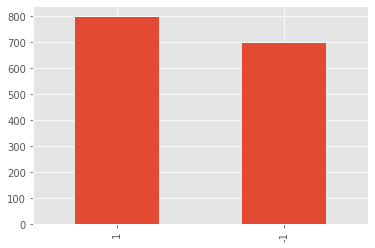

In [32]:
#Chart of Rise/fall
ax = sc_df["Rise/Fall"].value_counts().plot(kind = "bar")

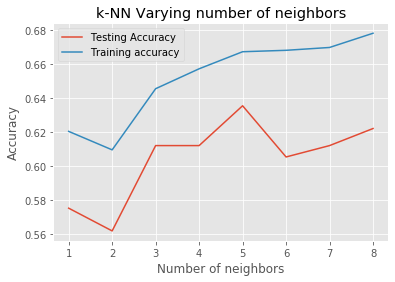

The accuracy score for KNN is: 0.6354515050167224


In [33]:
## KNN 
 
X_knn = sc_df.drop(columns=['Adj Close','Date','Stock','stock_price_change','Category','Rise/Fall'],axis=1).values
y_knn = sc_df['Rise/Fall'].values



#Splitting into test and train
X_train_knn,X_test_knn,y_train_knn,y_test_knn = tts(X_knn,y_knn,test_size=0.2,random_state=42, stratify=y_knn)


#Arrays to store data accuracy
neighbors = np.arange(1,9)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))


for i,k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_knn, y_train_knn)
    
    train_accuracy[i] = knn.score(X_train_knn, y_train_knn)
    test_accuracy[i] = knn.score(X_test_knn, y_test_knn)
    
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

# Fitting the model with k=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_knn, y_train_knn)
    
train_accuracy = knn.score(X_train_knn, y_train_knn)
test_accuracy = knn.score(X_test_knn, y_test_knn) 

#Accuracy:
print("The accuracy score for KNN is:",test_accuracy)

In [34]:
#Confusion Matrix
y_pred_knn = knn.predict(X_test_knn)
pd.crosstab(y_test_knn, y_pred_knn, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,-1,1,All
True,,,
-1,86,53,139
1,56,104,160
All,142,157,299


In [35]:
# Calculating Measures by hand
TP = 104
FP = 53
FN = 56
TN = 86
recall = TP/(TP+FN)
precision= TP/(TP+FP)
fmeasure = (2*recall*precision)/(recall+precision)
print("Recall: ",recall, "\nPrecision: ",precision, "\nF Measure: ", fmeasure)

Recall:  0.65 
Precision:  0.6624203821656051 
F Measure:  0.6561514195583596


In [36]:
print(classification_report(y_test_knn,y_pred_knn))

              precision    recall  f1-score   support

          -1       0.61      0.62      0.61       139
           1       0.66      0.65      0.66       160

    accuracy                           0.64       299
   macro avg       0.63      0.63      0.63       299
weighted avg       0.64      0.64      0.64       299



In [37]:
## Random Forest Classifier

rfc = RandomForestClassifier()

features=["tot_cases", "case_change", "tot_death", "death_change"]

X_rfc = sc_df.loc[:, features]
Y_rfc = sc_df["Rise/Fall"]
X_train_rfc, X_test_rfc, Y_train_rfc, Y_test_rfc = tts(X_rfc, Y_rfc, test_size=0.2, random_state=42)

rfc.fit(X_train_rfc, Y_train_rfc)
Y_pred_rfc = rfc.predict(X_test_rfc)

In [38]:
accuracy = metrics.accuracy_score(Y_test_rfc, Y_pred_rfc)
print("The accuracy score for random forest classifier is:", accuracy)

The accuracy score for random forest classifier is: 0.6688963210702341


In [39]:
pd.crosstab(Y_test_rfc, Y_pred_rfc, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,-1,1,All
True,,,
-1,79,64,143
1,35,121,156
All,114,185,299


In [40]:
TP = 121
FP = 64
FN = 35
TN = 79
recall = TP/(TP+FN)
precision = TP/(TP+FP)
fmeasure = (2*recall*precision)/(recall+precision)
print("Recall: ",recall, "\nPrecision: ",precision, "\nF Measure: ", fmeasure)

Recall:  0.7756410256410257 
Precision:  0.654054054054054 
F Measure:  0.7096774193548387


In [41]:
print(classification_report(Y_test_rfc,Y_pred_rfc))

              precision    recall  f1-score   support

          -1       0.69      0.55      0.61       143
           1       0.65      0.78      0.71       156

    accuracy                           0.67       299
   macro avg       0.67      0.66      0.66       299
weighted avg       0.67      0.67      0.66       299



In [46]:
## Decision Tree 
clf = tree.DecisionTreeClassifier(random_state=0)

features = ["tot_cases","new_case", "tot_death", "new_death"]
X_tree = sc_df.loc[:,features]
Y_tree = sc_df["Rise/Fall"]
X_train_tree, X_test_tree, Y_train_tree, Y_test_tree = tts(X_tree, Y_tree, test_size=0.2, random_state=42)

clf = clf.fit(X_train_tree,Y_train_tree)


#set how many folds/combinations you want
k=5
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_train_tree, Y_train_tree, cv=k)
#clf = clf.fit(X, Y)
scores

array([0.65833333, 0.61924686, 0.66108787, 0.69456067, 0.62761506])

In [47]:
#compute the mean accuracy, and the margin of error at 95% confidence interval. I.e., we are 95% confident that the mean
#accuracy is 68% +- 2 standard deviations/sqrt(k) (the more deviations the more confident we can be, widening the beam/net).
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), (scores.std() * 2)/k**(1/2)))
scores.mean()

Accuracy: 0.65 (+/- 0.02)


0.6521687587168759

TRAIN: [   0    2    3    4    6    7    9   11   12   13   15   16   17   19
   20   21   22   23   24   25   26   28   29   30   32   33   35   36
   37   38   40   41   42   43   44   46   47   48   50   51   53   54
   56   57   59   61   62   63   65   66   67   68   69   71   72   73
   74   76   77   78   79   80   81   83   84   86   87   88   89   90
   91   92   93   94   95   96   97   98   99  100  101  102  103  104
  105  106  107  109  110  111  112  113  114  115  116  117  118  119
  120  121  122  123  125  126  127  128  129  130  131  132  133  134
  135  136  137  138  139  140  143  144  145  146  147  148  149  150
  151  153  154  155  157  158  160  162  163  164  165  166  167  168
  169  170  171  172  173  174  175  176  177  178  179  180  181  182
  183  185  188  189  190  191  193  194  195  196  197  199  200  201
  203  205  206  207  208  209  210  212  213  214  215  216  217  218
  219  220  221  222  223  225  226  227  228  229  230  232  234  235

TypeError: 'builtin_function_or_method' object is not subscriptable

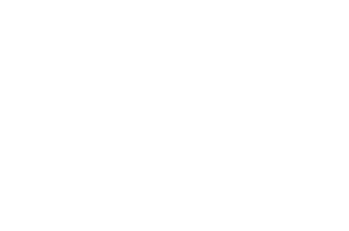

In [48]:
models = pd.DataFrame(columns=["score","model"])

#loop over all possible models
from sklearn.model_selection import KFold
#shuffle reorders the data for less bias
kf = KFold(n_splits = k, shuffle = True, random_state = 0)
i=0
for train_index, test_index in kf.split(X_train_tree):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train = X_train_tree.iloc[train_index]
    x_test = X_train_tree.iloc[test_index]
    y_train = Y_train_tree.iloc[train_index]
    y_test= Y_train_tree.iloc[test_index]
    
    #train the model
    model = clf.fit(x_train,y_train)
    predictions = clf.predict(x_test)
    print("model score = ",model.score(x_test,y_test))
    
    #print('Scores from each Iteration: ', scores)
    print('Average K-Fold Score :' , np.mean(scores)) 
    plt.figure()
    x = tree.plot_tree(model,rounded=True,filled=True,class_names=sorted,feature_names=features) 
    #assign model to dataframe
    models.loc[i] = [model.score(x_test,y_test),model]
    #clf = model
    #increment index in dataframe
    i = i+1

In [49]:
#get sorted labels for plot 
import numpy as np
sorted = Y_tree.unique()
sorted = np.sort(sorted)
sorted = list(map(str, sorted))
sorted

['-1', '1']

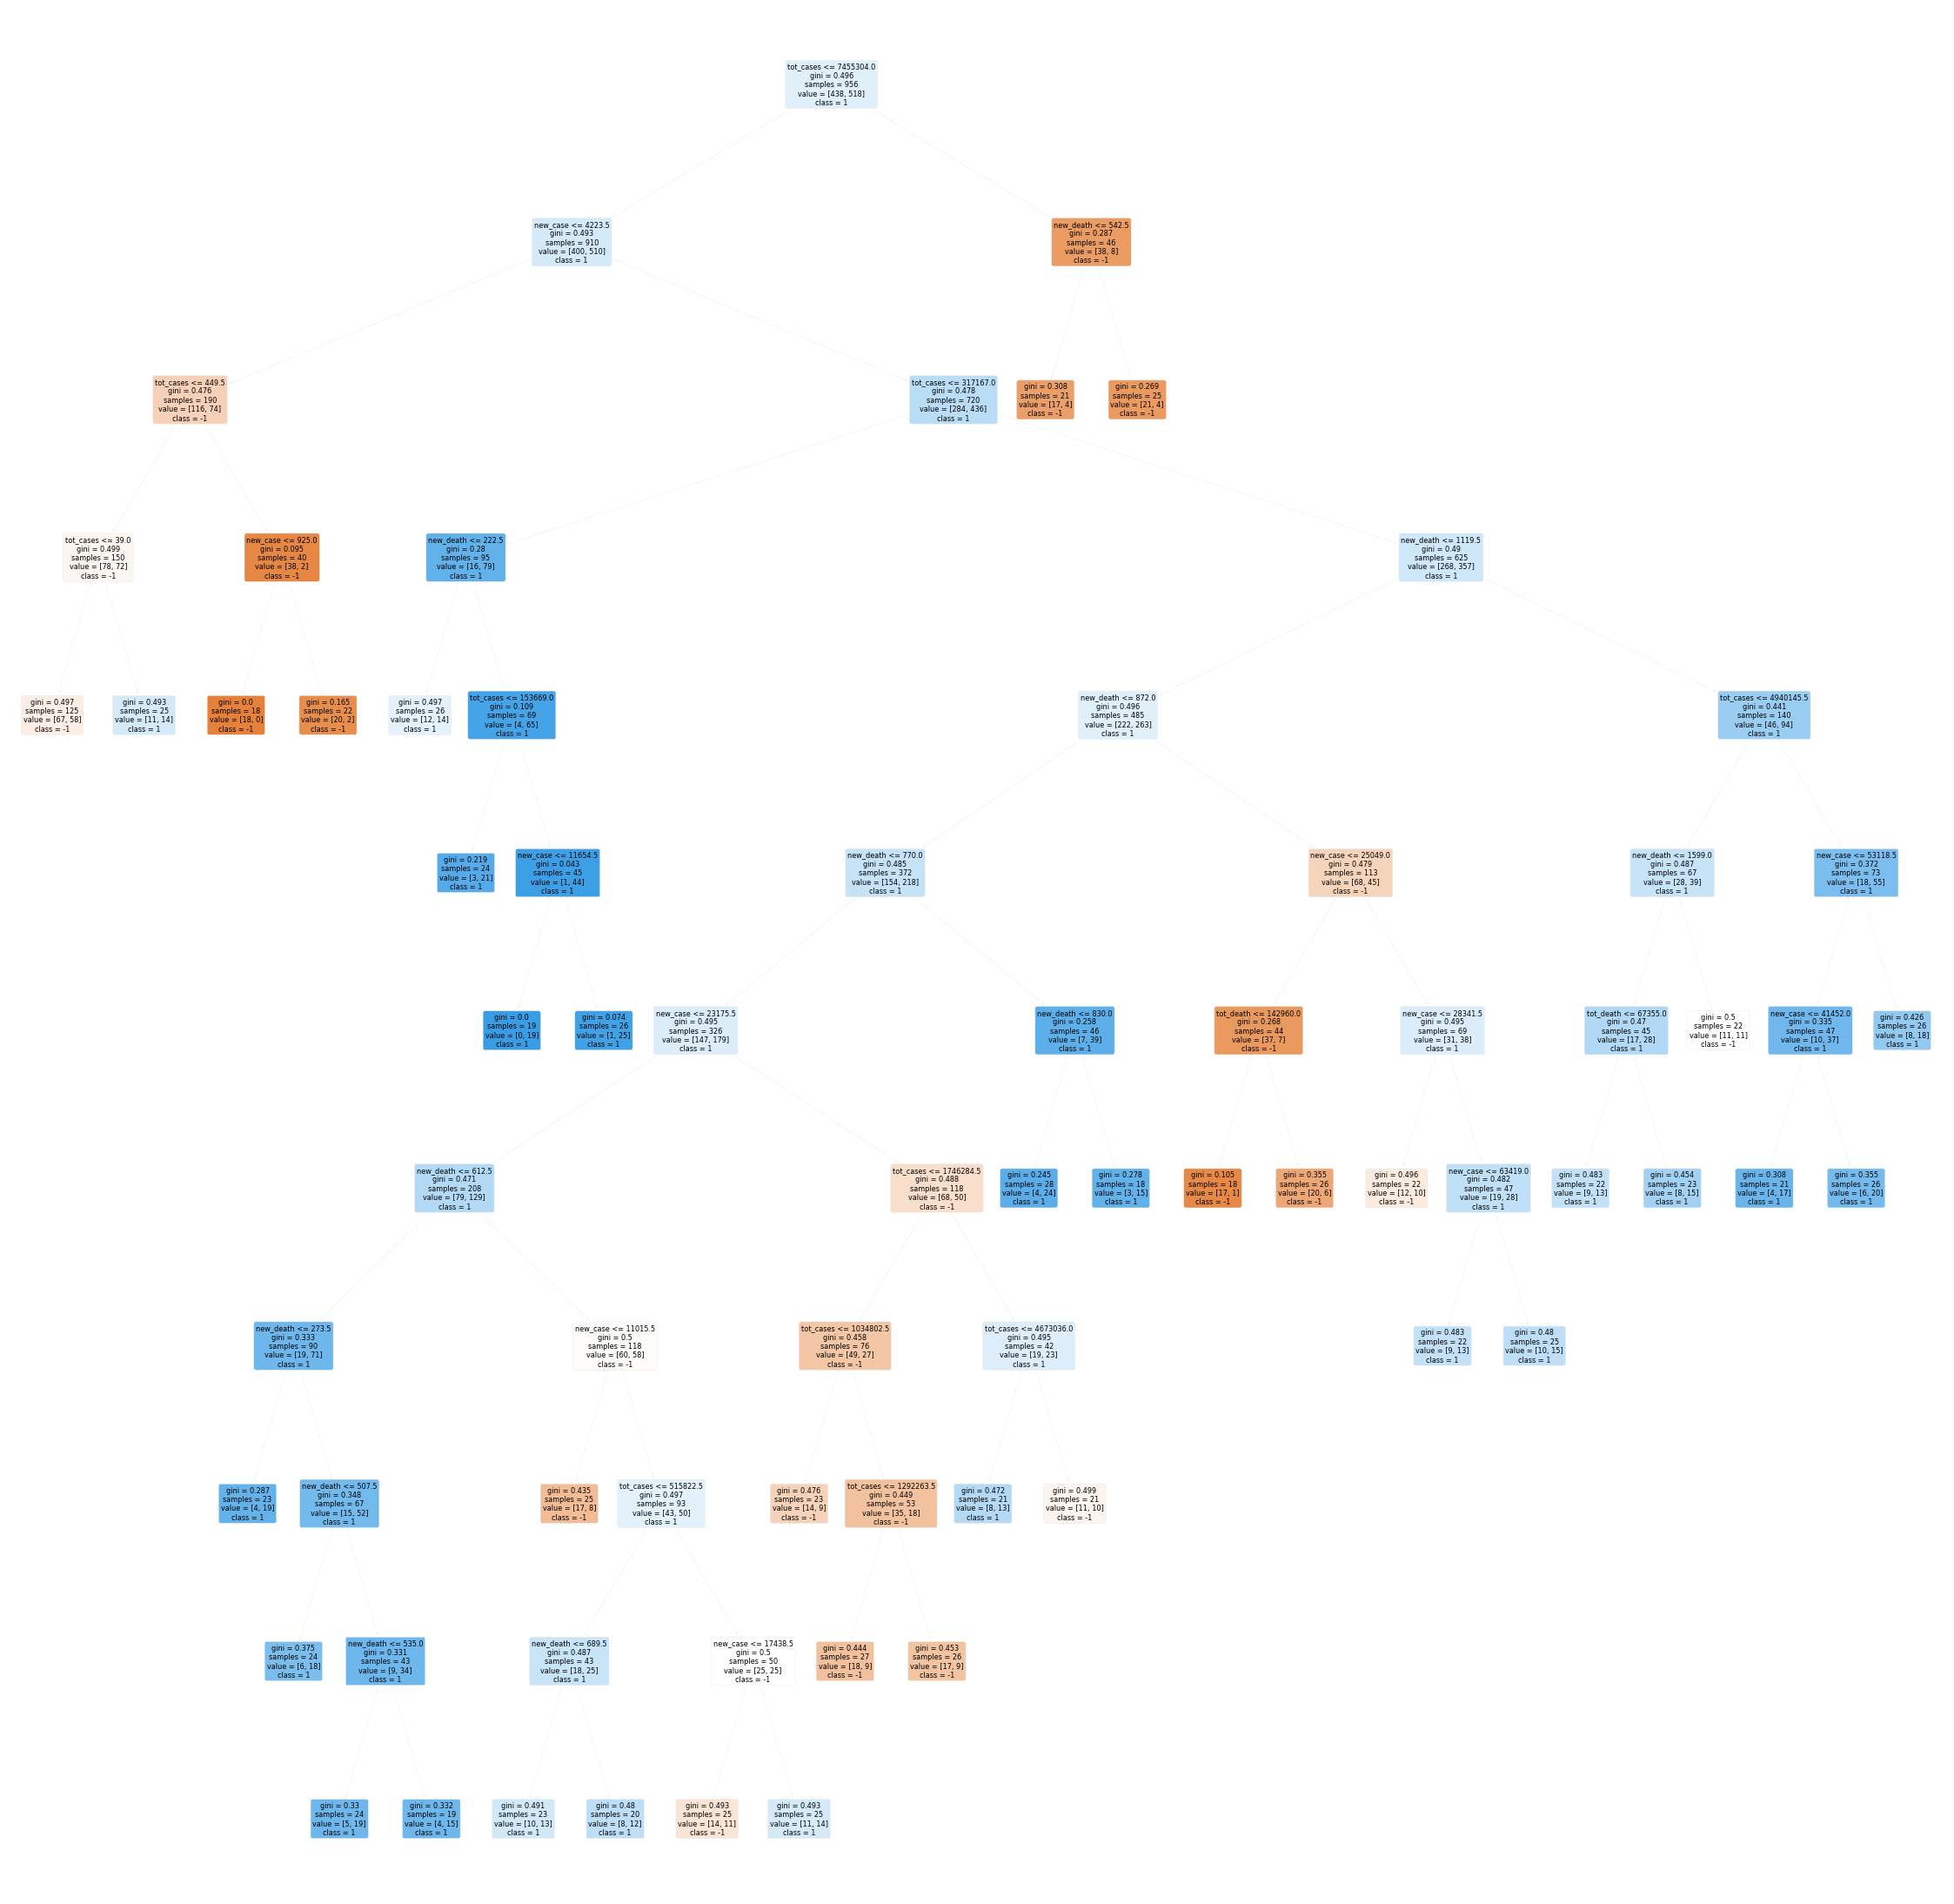

In [50]:
plt.subplots(figsize=(40, 40))
x = tree.plot_tree(clf,rounded=True,filled=True,class_names=sorted,feature_names=features) 

In [51]:
Y_pred_tree = clf.predict(X_test_tree)
accuracy = metrics.accuracy_score(Y_test_tree, Y_pred_tree)

print("The accuracy score for random forest classifier is:", accuracy)

The accuracy score for random forest classifier is: 0.6588628762541806


In [52]:
# pairwise correlation of columns
covid_stocks_dummies = pd.concat([sc_df, pd.get_dummies(sc_df["Category"], prefix="Dummy")], axis = 1)
covid_stocks_dummies.corr()

,Adj Close,stock_price_change,tot_cases,new_case,tot_death,new_death,case_change,death_change,Dummy_biotech,Dummy_consumer,Dummy_energy,Dummy_healthCare,Dummy_it,Dummy_pharmacy,Dummy_realEstate,Dummy_retail,Dummy_utility
Adj Close,1.000000,0.026117,0.035376,0.023110,0.035353,0.028766,-0.006201,-0.006564,-0.129367,-0.025588,-0.108555,-0.073086,-0.076587,-0.079579,0.057644,0.455654,-0.034907
stock_price_change,0.026117,1.000000,-0.013239,0.040776,-0.009956,0.095503,-0.034552,-0.036670,0.049084,-0.001897,-0.062236,-0.022040,0.009339,0.003476,0.005049,0.027554,-0.008750
tot_cases,0.035376,-0.013239,1.000000,0.431780,0.988051,0.631177,0.100687,0.092523,-0.004811,-0.002907,-0.004811,-0.004811,-0.003614,-0.004811,-0.004811,0.032316,-0.002907
new_case,0.023110,0.040776,0.431780,1.000000,0.386031,0.704271,0.113820,0.106491,-0.003409,-0.002060,-0.003409,-0.003409,-0.002561,-0.003409,-0.003409,0.022898,-0.002060
tot_death,0.035353,-0.009956,0.988051,0.386031,1.000000,0.578612,0.110084,0.102070,-0.004538,-0.002743,-0.004538,-0.004538,-0.003409,-0.004538,-0.004538,0.030483,-0.002743
new_death,0.028766,0.095503,0.631177,0.704271,0.578612,1.000000,0.210997,0.198894,-0.003678,-0.002223,-0.003678,-0.003678,-0.002762,-0.003678,-0.003678,0.024704,-0.002223
case_change,-0.006201,-0.034552,0.100687,0.113820,0.110084,0.210997,1.000000,0.999857,0.000857,0.000518,0.000857,0.000857,0.000643,0.000857,0.000857,-0.005753,0.000518
death_change,-0.006564,-0.036670,0.092523,0.106491,0.102070,0.198894,0.999857,1.000000,0.000903,0.000546,0.000903,0.000903,0.000679,0.000903,0.000903,-0.006068,0.000546
Dummy_biotech,-0.129367,0.049084,-0.004811,-0.003409,-0.004538,-0.003678,0.000857,0.000903,1.000000,-0.096032,-0.158915,-0.158915,-0.119360,-0.158915,-0.158915,-0.148881,-0.096032
Dummy_consumer,-0.025588,-0.001897,-0.002907,-0.002060,-0.002743,-0.002223,0.000518,0.000546,-0.096032,1.000000,-0.096032,-0.096032,-0.072129,-0.096032,-0.096032,-0.089969,-0.058033


In [53]:

finalVars = ["Rise/Fall","stock_price_change",
             "death_change","case_change",
             "Dummy_biotech", "Dummy_consumer",
             "Dummy_energy", "Dummy_it","Dummy_pharmacy",
             "Dummy_retail", "Dummy_utility", 
             "Dummy_realEstate", "Dummy_healthCare"]
final = covid_stocks_dummies.loc[:,finalVars]
final.corr()

,stock_price_change,death_change,case_change,Dummy_biotech,Dummy_consumer,Dummy_energy,Dummy_it,Dummy_pharmacy,Dummy_retail,Dummy_utility,Dummy_realEstate,Dummy_healthCare
stock_price_change,1.000000,-0.036670,-0.034552,0.049084,-0.001897,-0.062236,0.009339,0.003476,0.027554,-0.008750,0.005049,-0.022040
death_change,-0.036670,1.000000,0.999857,0.000903,0.000546,0.000903,0.000679,0.000903,-0.006068,0.000546,0.000903,0.000903
case_change,-0.034552,0.999857,1.000000,0.000857,0.000518,0.000857,0.000643,0.000857,-0.005753,0.000518,0.000857,0.000857
Dummy_biotech,0.049084,0.000903,0.000857,1.000000,-0.096032,-0.158915,-0.119360,-0.158915,-0.148881,-0.096032,-0.158915,-0.158915
Dummy_consumer,-0.001897,0.000546,0.000518,-0.096032,1.000000,-0.096032,-0.072129,-0.096032,-0.089969,-0.058033,-0.096032,-0.096032
Dummy_energy,-0.062236,0.000903,0.000857,-0.158915,-0.096032,1.000000,-0.119360,-0.158915,-0.148881,-0.096032,-0.158915,-0.158915
Dummy_it,0.009339,0.000679,0.000643,-0.119360,-0.072129,-0.119360,1.000000,-0.119360,-0.111824,-0.072129,-0.119360,-0.119360
Dummy_pharmacy,0.003476,0.000903,0.000857,-0.158915,-0.096032,-0.158915,-0.119360,1.000000,-0.148881,-0.096032,-0.158915,-0.158915
Dummy_retail,0.027554,-0.006068,-0.005753,-0.148881,-0.089969,-0.148881,-0.111824,-0.148881,1.000000,-0.089969,-0.148881,-0.148881
Dummy_utility,-0.008750,0.000546,0.000518,-0.096032,-0.058033,-0.096032,-0.072129,-0.096032,-0.089969,1.000000,-0.096032,-0.096032


[30.0, 5.0]
[[368 185]
 [198 445]]


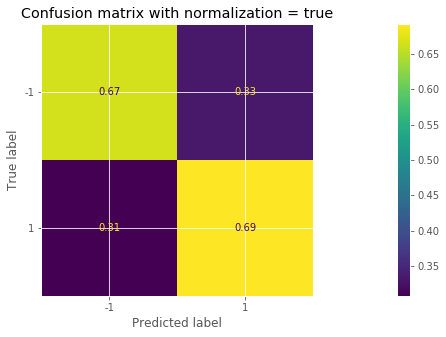

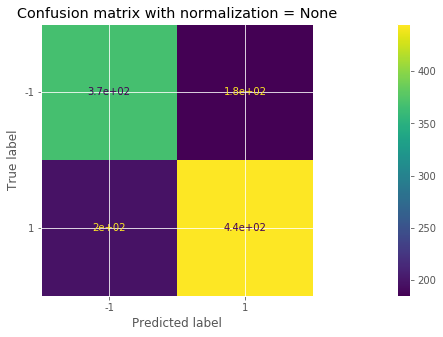

In [54]:
#setup plots for confusion matrix
from sklearn.metrics import plot_confusion_matrix as matrix
figSize = plt.rcParams["figure.figsize"]
figSize[0] = 30
figSize[1] = 5
plt.rcParams["figure.figsize"]=figSize
print(plt.rcParams.get('figure.figsize'))

#plot the confusion matrices 1 for normalzied the other un-normalized
values = ['true',None]
#cmap='cividis'
for x in values:
    disp = matrix(clf,X_train_tree,Y_train_tree,display_labels=sorted,normalize=x)
    disp.ax_.set_title("Confusion matrix with normalization = "+str(x))
print(disp.confusion_matrix)